# Assignent 4 by Ludvig Flodin (ludflo-0)

Disclaimer: This code is supported with github copilot

# Part 1 anomaly detection

### Task 1 - What is anomaly detection?

Anomaly detection means to identify data points that deviate from the expected normal distibution of the baseline data. If we assume that the normal follows a pattern or a normal distribution, if the new dataponts probability of being in that set is very low, it is considered an anomaly.

The types of anomalies are Point anomalies, contextual anomalies and collective anomalies (taken from anomalo.com).
Point anomalies are a single data point that significantly deviates from the rest of the data.
Contextual Anomalies is more related to context and can be related to software bugs. An example could be faulty sensors, missing data. Some sort of data that should be impossible.
Collective anomalies are a group of datapoints that are anomalous. It could be a disturbance of some sort.




### Task 2-7

## Import dataset

Train batch dimensions: torch.Size([69, 1, 28, 28])
Test batch dimensions: torch.Size([69, 1, 28, 28])


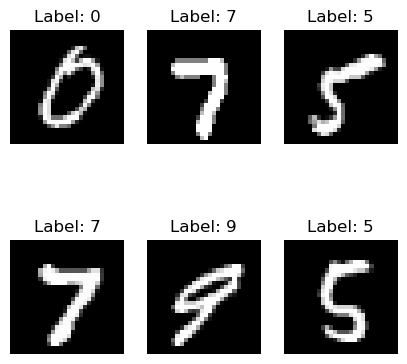

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [83]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),       
    transforms.Normalize((0.5,), (0.5,)) 
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 69
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# check dimension (batch_size, channel, height, width)
for images, labels in train_loader:
    print("Train batch dimensions:", images.shape)
    break

for images, labels in test_loader:
    print("Test batch dimensions:", images.shape)
    break

train_examples = iter(train_loader)
test_examples = iter(test_loader)
example_data, example_targets = next(train_examples)
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')
plt.show()

print(example_data)

## Model and training

In [22]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),    
            nn.ReLU(),
            nn.Linear(128, 64),       
            nn.ReLU(),
            nn.Linear(64, 12)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()                  
        )

    def forward(self, x):
            x = x.view(x.size(0), -1) # flatten the input
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            decoded = decoded.view(x.size(0), 1, 28, 28) # restore shape
            return decoded

Epoch [1/20], Loss: 0.154441
Epoch [2/20], Loss: 0.092909
Epoch [3/20], Loss: 0.082373
Epoch [4/20], Loss: 0.076927
Epoch [5/20], Loss: 0.072897
Epoch [6/20], Loss: 0.069976
Epoch [7/20], Loss: 0.067872
Epoch [8/20], Loss: 0.066030
Epoch [9/20], Loss: 0.064631
Epoch [10/20], Loss: 0.063380
Epoch [11/20], Loss: 0.062297
Epoch [12/20], Loss: 0.061426
Epoch [13/20], Loss: 0.060606
Epoch [14/20], Loss: 0.059832
Epoch [15/20], Loss: 0.059203
Epoch [16/20], Loss: 0.058629
Epoch [17/20], Loss: 0.058086
Epoch [18/20], Loss: 0.057621
Epoch [19/20], Loss: 0.057156
Epoch [20/20], Loss: 0.056795


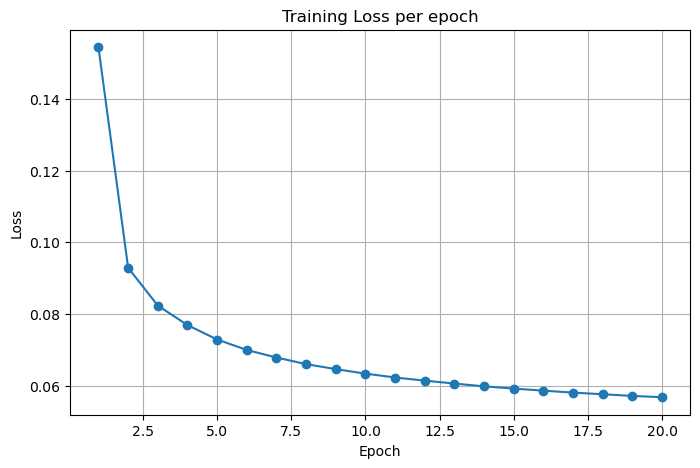

In [23]:
import matplotlib.pyplot as plt

# params
model = Autoencoder()
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
num_epochs = 20

train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

torch.save(model.state_dict(), 'autoencoder.pth')

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## Gaussian noise

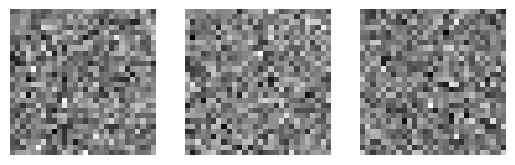

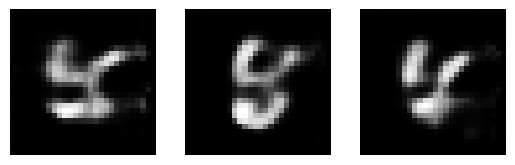

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.85      0.92     10000
     Anomaly       0.41      1.00      0.58      1000

    accuracy                           0.87     11000
   macro avg       0.70      0.93      0.75     11000
weighted avg       0.95      0.87      0.89     11000



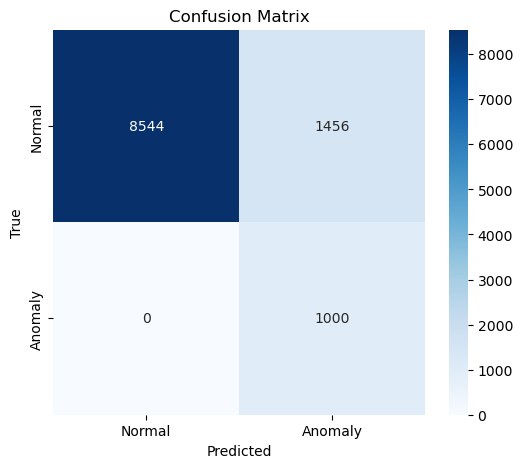

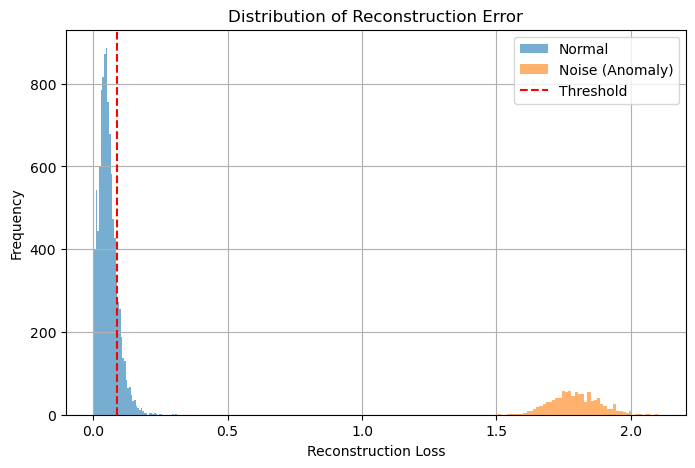

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def generate_gaussian_noise_images(n_samples, image_size=(28, 28), mean=0.0, std=1.0):
    noise = torch.randn(n_samples, 1, *image_size) * std + mean
    noise - torch.clamp(noise, -1, 1)  # normalize to [-1, 1]
    return noise

def generate_uniform_noise_images(n_samples, image_size=(28, 28)):
    noise = torch.rand(n_samples, 1, *image_size) * 2 - 1  
    return noise

model.eval()
normal_losses = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        loss = torch.mean((outputs - images) ** 2, dim=[1,2,3])
        normal_losses.extend(loss.numpy())


# calculate loss for anomalies
noise_images = generate_gaussian_noise_images(1000)
# noise_images = generate_uniform_noise_images(1000)
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(noise_images[i][0], cmap='gray')
    plt.axis('off')
plt.show()

with torch.no_grad():
    for images in noise_images:
        recon_noise = model(noise_images)
        noise_loss = torch.mean((recon_noise - noise_images)**2, dim=[1,2,3])
        noise_losses = noise_loss.numpy()

for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(recon_noise[i][0], cmap='gray')
    plt.axis('off')
plt.show()

threshold = np.mean(normal_losses) + np.std(normal_losses)

# classify
normal_pred = [0 if l <= threshold else 1 for l in normal_losses]  # 0 = normal
noise_pred  = [0 if l <= threshold else 1 for l in noise_losses]   # 1 = anomaly

y_pred = normal_pred + noise_pred
y_true = [0] * len(normal_pred) + [1] * len(noise_pred)


cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"])

print("Classification Report:\n", report)

# confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plot reconstruction error distribution
plt.figure(figsize=(8,5))
plt.hist(normal_losses, bins=50, alpha=0.6, label='Normal')
plt.hist(noise_losses, bins=50, alpha=0.6, label='Noise (Anomaly)')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Reconstruction Error')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Uniform noise

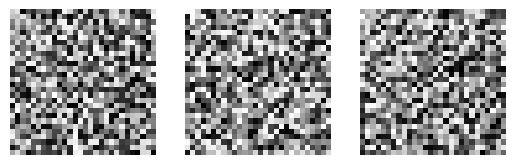

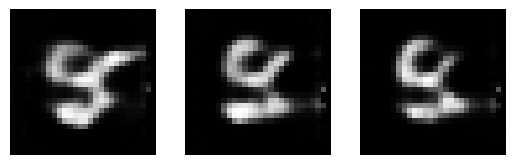

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.85      0.92     10000
     Anomaly       0.41      1.00      0.58      1000

    accuracy                           0.87     11000
   macro avg       0.70      0.93      0.75     11000
weighted avg       0.95      0.87      0.89     11000



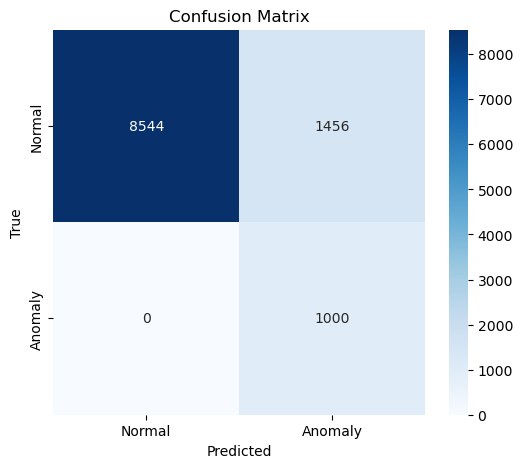

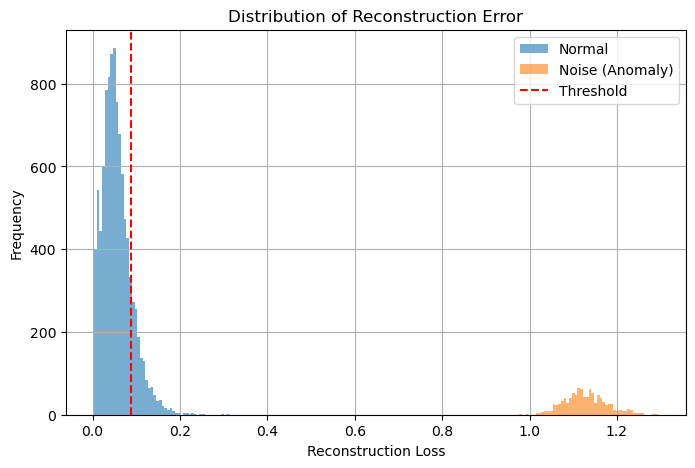

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def generate_gaussian_noise_images(n_samples, image_size=(28, 28), mean=0.0, std=1.0):
    noise = torch.randn(n_samples, 1, *image_size) * std + mean
    return noise

def generate_uniform_noise_images(n_samples, image_size=(28, 28)):
    noise = torch.rand(n_samples, 1, *image_size) * 2 - 1  
    return noise
def calculate_reconstruction_loss(model, data, mode):
        with torch.no_grad():
            reconstructions = model(data)
            if mode == 'abs':
                reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)  
            elif mode == 'mse':
                reconstruction_errors = np.mean((data - reconstructions) ** 2, axis=1)
            return reconstruction_errors

model.eval()
normal_losses = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        loss = torch.mean((outputs - images) ** 2, dim=[1,2,3])
        normal_losses.extend(loss.numpy())


# calculate loss for anomalies

# noise_images = generate_gaussian_noise_images(1000)
noise_images = generate_uniform_noise_images(1000)
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(noise_images[i][0], cmap='gray')
    plt.axis('off')
plt.show()

with torch.no_grad():
    for images in noise_images:
        recon_noise = model(noise_images)
        noise_loss = torch.mean((recon_noise - noise_images)**2, dim=[1,2,3])
        noise_losses = noise_loss.numpy()

for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(recon_noise[i][0], cmap='gray')
    plt.axis('off')
plt.show()

threshold = np.mean(normal_losses) + np.std(normal_losses)

# classify
normal_pred = [0 if l <= threshold else 1 for l in normal_losses]  # 0 = normal
noise_pred  = [0 if l <= threshold else 1 for l in noise_losses]   # 1 = anomaly

y_pred = normal_pred + noise_pred
y_true = [0] * len(normal_pred) + [1] * len(noise_pred)


cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"])

print("Classification Report:\n", report)

# confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plot reconstruction error distribution
plt.figure(figsize=(8,5))
plt.hist(normal_losses, bins=50, alpha=0.6, label='Normal')
plt.hist(noise_losses, bins=50, alpha=0.6, label='Noise (Anomaly)')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Reconstruction Error')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Task 8 - Explain the steps to implement anomaly detection algorithm

The main part is to discriminate normal values to anomalious values. 
By using semi-superviesd machine learning (like this) we can establish a normal loss function from the training set and disciminate anomalies based on loss. 
An other way is to measure anomalous datapoints in real time, so if a value is considered too far off, it can be considered an anomaly. 

# Part 2

## Load MNIST 0-8

In [ ]:
import numpy as np
import pandas as pd
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


mnist = MNIST(root='./data', train=True, download=True, transform=ToTensor())

data = []

for img, label in mnist:
    if label < 9:
        img_np = img.squeeze().numpy()  # [28x28] to numpy
        mean = np.mean(img_np)
        std = np.std(img_np)
        data.append((label, mean, std))

df = pd.DataFrame(data, columns=['digit', 'mean', 'std'])

df.head()


,digit,mean,std
0,5,0.137680,0.312348
1,0,0.155537,0.328969
2,4,0.097254,0.257175
3,1,0.085709,0.259133
4,2,0.148064,0.318058


## Classify

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# split the dataset
X = df[['mean', 'std']].values
y = df['digit'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

df_train = pd.DataFrame(X_train, columns=['mean', 'std'])
df_train['digit'] = y_train

# calculate centroids
centroids = df_train.groupby('digit')[['mean', 'std']].mean()

y_pred = []

for point in X_test:
    distances = np.linalg.norm(centroids.values - point, axis=1)
    closest_class = centroids.index[np.argmin(distances)]
    y_pred.append(closest_class)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.274     0.630     0.382      1185
           1      0.442     0.785     0.566      1349
           2      0.132     0.107     0.119      1192
           3      0.142     0.055     0.079      1226
           4      0.128     0.061     0.082      1168
           5      0.110     0.071     0.086      1084
           6      0.117     0.067     0.085      1184
           7      0.180     0.280     0.219      1253
           8      0.187     0.058     0.089      1170

    accuracy                          0.245     10811
   macro avg      0.190     0.235     0.190     10811
weighted avg      0.195     0.245     0.196     10811



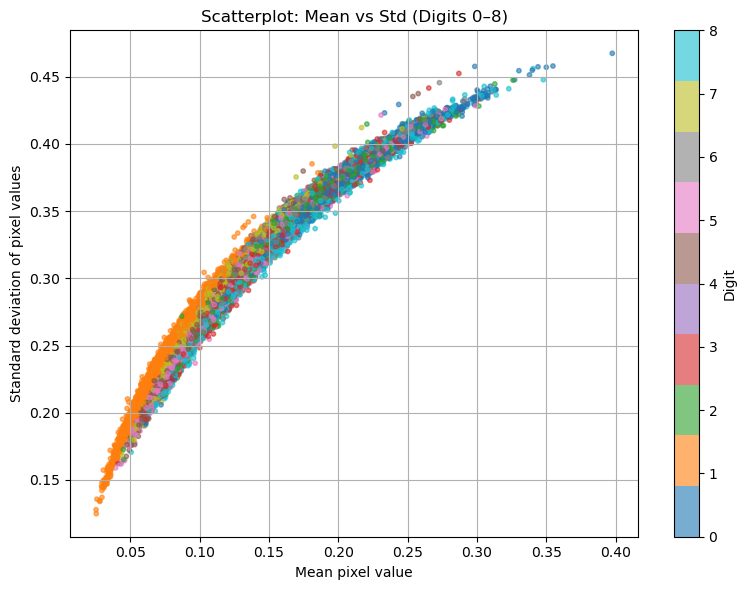

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
scatter = plt.scatter(df['mean'], df['std'], c=df['digit'], cmap='tab10', s=10, alpha=0.6)

plt.title("Scatterplot: Mean vs Std (Digits 0–8)")
plt.xlabel("Mean pixel value")
plt.ylabel("Standard deviation of pixel values")
plt.colorbar(scatter, label="Digit")
plt.grid(True)
plt.tight_layout()
plt.show()



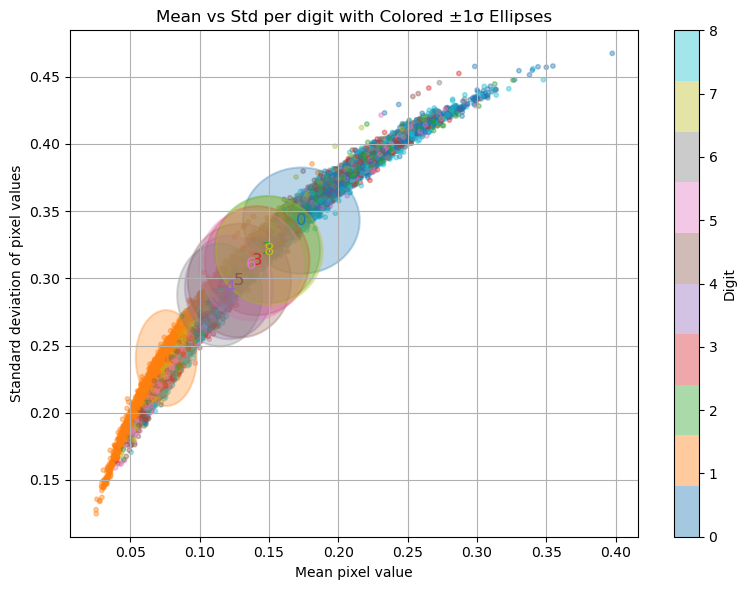

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


grouped = df.groupby('digit')
centroids = grouped[['mean', 'std']].mean()
spreads = grouped[['mean', 'std']].std()


cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(9)]


fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(df['mean'], df['std'], c=df['digit'], cmap='tab10', s=10, alpha=0.4)
for digit in centroids.index:
    mu = centroids.loc[digit]
    stddev = spreads.loc[digit]
    color = colors[digit]
    
    ellipse = Ellipse(xy=(mu['mean'], mu['std']),
                      width=2 * stddev['mean'],
                      height=2 * stddev['std'],
                      edgecolor=color,
                      facecolor=color,
                      lw=1.5,
                      alpha=0.3)
    ax.add_patch(ellipse)
    
    ax.text(mu['mean'], mu['std'], str(digit), fontsize=12, color=color, ha='center', va='center')


ax.set_title("Mean vs Std per digit with Colored ±1σ Ellipses")
ax.set_xlabel("Mean pixel value")
ax.set_ylabel("Standard deviation of pixel values")
fig.colorbar(scatter, label="Digit", ax=ax)
ax.grid(True)
plt.tight_layout()
plt.show()



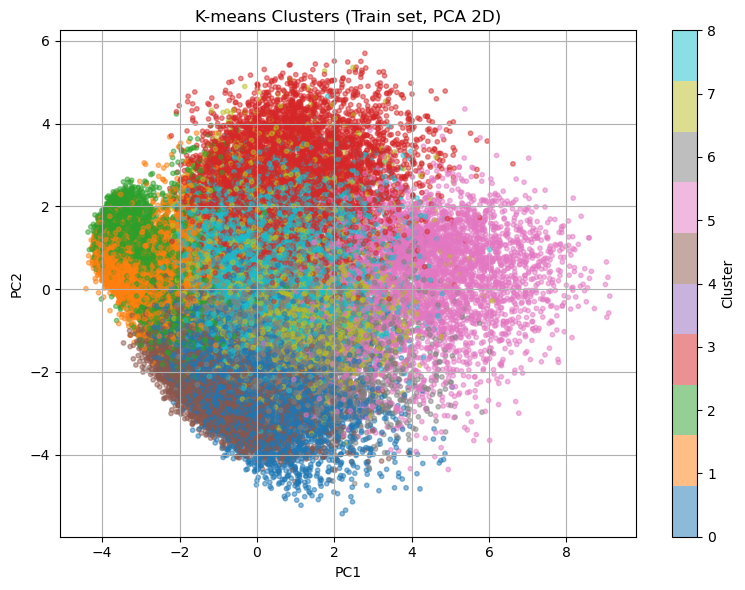

Classification Report:
              precision    recall  f1-score   support

           0      0.943     0.803     0.867      1185
           1      0.604     0.992     0.751      1349
           2      0.889     0.690     0.777      1192
           3      0.502     0.657     0.569      1226
           4      0.758     0.898     0.822      1168
           5      0.000     0.000     0.000      1084
           6      0.885     0.814     0.848      1184
           7      0.927     0.813     0.866      1253
           8      0.441     0.559     0.493      1170

    accuracy                          0.703     10811
   macro avg      0.661     0.692     0.666     10811
weighted avg      0.668     0.703     0.674     10811

Test ARI: 0.4852197436221553
Test NMI: 0.5606948363873948


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, classification_report

from scipy.stats import mode
import os
os.environ["OMP_NUM_THREADS"] = "1"  # fix for deadlock

mnist = MNIST(root='./data', train=True, download=True, transform=ToTensor())
images = []
labels = []

for img, label in mnist:
    if label < 9:
        images.append(img.view(-1).numpy())  # flatten 28x28
        labels.append(label)

X = np.array(images)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

kmeans = KMeans(n_clusters=9, random_state=42)
y_kmeans_train = kmeans.fit_predict(X_train)

# plot pca 
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_kmeans_train, cmap='tab10', s=10, alpha=0.5)
plt.title("K-means Clusters (Train set, PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


y_pred_test = kmeans.predict(X_test)

# match cluster to digit
cluster_to_digit = {}

for cluster in range(9):
    indices = np.where(y_kmeans_train == cluster)
    if len(indices[0]) == 0:
        continue
    majority_label = mode(y_train[indices], keepdims=True).mode[0]
    cluster_to_digit[cluster] = majority_label


y_test_pred_digits = [cluster_to_digit[c] for c in y_pred_test]


print("Classification Report:")
print(classification_report(y_test, y_test_pred_digits, digits=3))
print("Test ARI:", adjusted_rand_score(y_test, y_pred_test))
print("Test NMI:", normalized_mutual_info_score(y_test, y_pred_test))


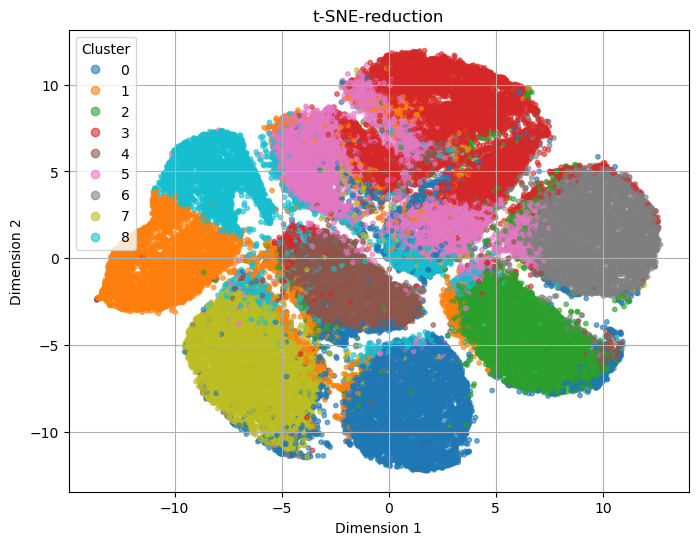

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, cmap='tab10', s=10, alpha=0.6)
plt.title('t-SNE-reduction')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

# Part 3

In [17]:
import pandas as pd
import numpy as np
# load files
rul = pd.read_csv('/Users/ludvigflodin/Documents/Courses/D7017B/Assignment 4 PHM/CMaps/RUL_FD001.txt', header=None, names=['RUL'])
train = pd.read_csv('/Users/ludvigflodin/Documents/Courses/D7017B/Assignment 4 PHM/CMaps/train_FD001.txt', sep="\s+", header=None)
test = pd.read_csv('/Users/ludvigflodin/Documents/Courses/D7017B/Assignment 4 PHM/CMaps/test_FD001.txt', sep="\s+", header=None)

# set columns
columns = ['engine_id', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
train.columns = columns
test.columns = columns

# add RUL to train, by engine_id
rul_train = train.groupby('engine_id')['cycle'].max().reset_index()
rul_train.columns = ['engine_id', 'max_cycle']

# merge RUL with train
train = train.merge(rul_train, on='engine_id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# add RUL to test, by engine_id
test = test.groupby('engine_id').tail(1).copy().reset_index(drop=True)
test['RUL'] = rul["RUL"]

feature_cols = [f'sensor_{i}' for i in range(1, 22)]
X_train = train[feature_cols]
y_train = train['RUL']

X_test = test[feature_cols]
y_test = test['RUL']

train.head(-1)

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_18083/2262502576.py:5: SyntaxWarning: invalid escape sequence '\s'
  train = pd.read_csv('/Users/ludvigflodin/Documents/Courses/D7017B/Assignment 4 PHM/CMaps/train_FD001.txt', sep="\s+", header=None)
/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_18083/2262502576.py:6: SyntaxWarning: invalid escape sequence '\s'
  test = pd.read_csv('/Users/ludvigflodin/Documents/Courses/D7017B/Assignment 4 PHM/CMaps/test_FD001.txt', sep="\s+", header=None)


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,100,195,-0.0002,-0.0001,100.0,518.67,643.41,1600.04,1431.90,14.62,...,2388.28,8142.90,8.5519,0.03,394,2388,100.0,38.14,23.1923,5
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2


In [18]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# features
feature_cols = [f'sensor_{i}' for i in range(1, 22)]
X_train = train[feature_cols]
y_train = train['RUL']

X_test = test[feature_cols]
y_test = test['RUL']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train SVR
svr = SVR(epsilon=0.5) 
svr.fit(X_train_scaled, y_train)

# predict
y_pred = svr.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"SVR RMSE: {rmse:.2f}")

SVR RMSE: 26.66


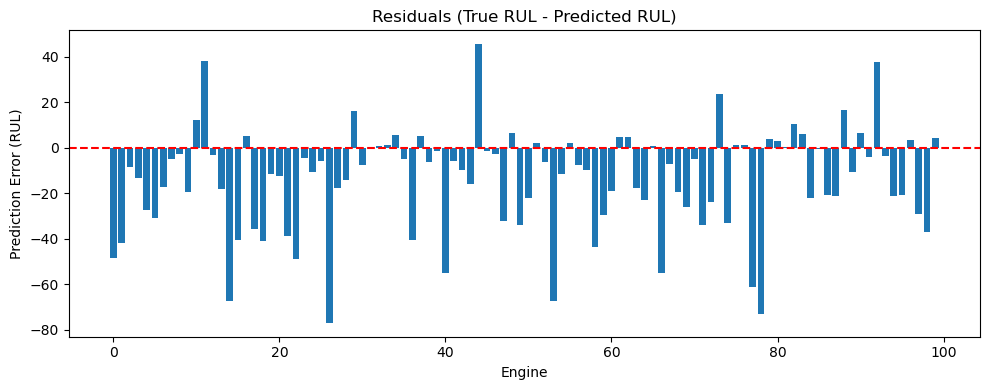

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(10,4))
plt.bar(range(len(residuals)), residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (True RUL - Predicted RUL)")
plt.xlabel("Engine")
plt.ylabel("Prediction Error (RUL)")
plt.tight_layout()
plt.show()

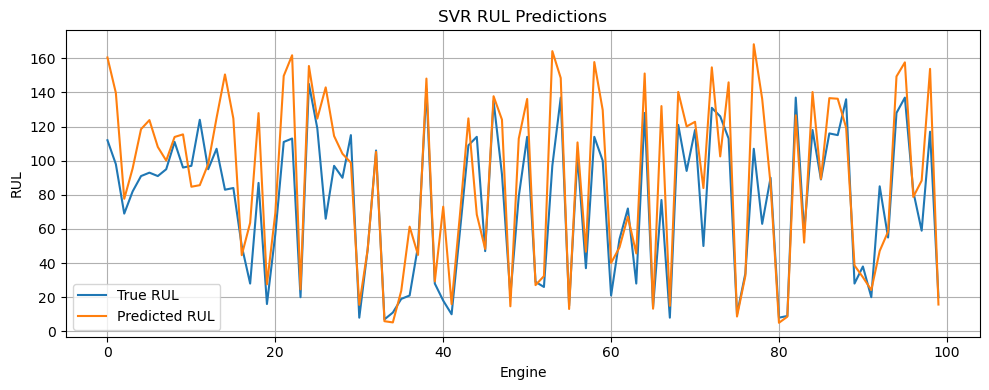

In [80]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="True RUL")
plt.plot(y_pred, label="Predicted RUL")
plt.legend()
plt.title("SVR RUL Predictions")
plt.xlabel("Engine")
plt.ylabel("RUL")
plt.grid(True)
plt.tight_layout()
plt.show()